In [59]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from glob import glob
import json
import os
import sys
sys.path.append(os.path.abspath(os.getcwd() + "./../"))

In [60]:
import torch
from IPython.display import Image as IPythonImage
from PIL import Image, ImageDraw, ImageFont
import io
from tasks.patterntask import dataloader
from train import evaluate

In [73]:
batch_num = 60000
files = glob("patterntask-1000-batch-60000.json".format(batch_num))
files

['patterntask-1000-batch-60000.json']

In [74]:
history = [json.loads(open(fname, "rt").read()) for fname in files]
training = np.array([(x['cost'], x['loss'], x['seq_lengths']) for x in history])
print("Training history (seed x metric x sequence) =", training.shape)

Training history (seed x metric x sequence) = (1, 3, 60000)


In [75]:
# Average every dv values across each (seed, metric)
dv = 2000
training = training.reshape(len(files), 3, -1, dv).mean(axis=3)
print(training.shape)

(1, 3, 30)


In [76]:
# Average the seeds
training_mean = training.mean(axis=0)
training_std = training.std(axis=0)
print(training_mean.shape)
print(training_std.shape)

(3, 30)
(3, 30)


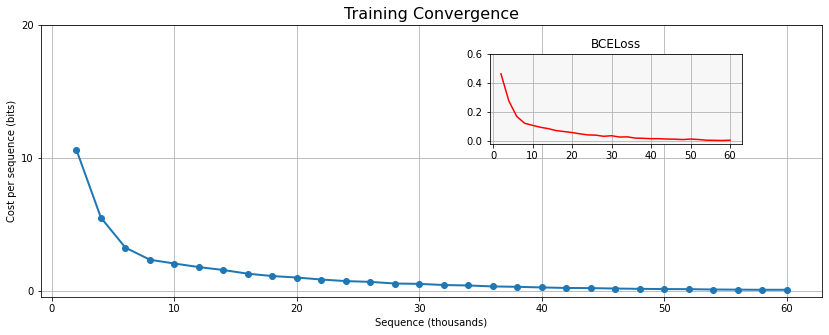

In [77]:
fig = plt.figure(figsize=(14, 5))

# X axis is normalized to thousands
x = np.arange(dv / 1000, (batch_num / 1000) + (dv / 1000), dv / 1000)

# Plot the cost
# plt.plot(x, training_mean[0], 'o-', linewidth=2, label='Cost')
plt.errorbar(x, training_mean[0], yerr=training_std[0], fmt='o-', elinewidth=2, linewidth=2, label='Cost')
plt.grid()
plt.yticks(np.arange(0, training_mean[0][0]+10, 10))
plt.ylabel('Cost per sequence (bits)')
plt.xlabel('Sequence (thousands)')
plt.title('Training Convergence', fontsize=16)

ax = plt.axes([.57, .55, .25, .25], facecolor=(0.97, 0.97, 0.97))
plt.title("BCELoss")
plt.plot(x, training_mean[1], 'r-', label='BCE Loss')
plt.yticks(np.arange(0, training_mean[1][0]+0.2, 0.2))
plt.grid()

plt.show()

In [87]:
#history[0]

In [61]:
from tasks.patterntask import patternModelTraining
model = patternModelTraining()

In [62]:
model.net.load_state_dict(torch.load("./patterndetect/patterntask-1000-batch-60000.model"))

<All keys matched successfully>

In [63]:
def cmap(value):
    pixval = value * 255
    low = 64
    high = 240
    factor = (255 - low - (255-high)) / 255
    return int(low + pixval * factor)

def draw_sequence(y, u=12):
    seq_len = y.size(0)
    seq_width = y.size(2)
    inset = u // 8
    pad = u // 2
    width = seq_len * u + 2 * pad
    height = seq_width * u + 2 * pad
    im = Image.new('L', (width, height))
    draw = ImageDraw.ImageDraw(im)
    draw.rectangle([0, 0, width, height], fill=250)
    for i in range(seq_len):
        for j in range(seq_width):
            val = 1 - y[i, 0, j].data[0]
            draw.rectangle([pad + i*u + inset,
                            pad + j*u + inset,
                            pad + (i+1)*u - inset,
                            pad + (j+1)*u - inset], fill=cmap(val))

    return im

def im_to_png_bytes(im):
    png = io.BytesIO()
    im.save(png, 'PNG')
    return bytes(png.getbuffer())

def im_vconcat(im1, im2, pad=8):
    assert im1.size == im2.size
    w, h = im1.size

    width = w
    height = h * 2 + pad

    im = Image.new('L', (width, height), color=255)
    im.paste(im1, (0, 0))
    im.paste(im2, (0, h+pad))
    return im

In [64]:
def make_eval_plot(y, y_out, u=12):
    im_y = draw_sequence(y, u)
    im_y_out = draw_sequence(y_out, u)
    im = im_vconcat(im_y, im_y_out, u//2)
    
    w, h = im.size
    pad_w = u * 7
    im2 = Image.new('L', (w+pad_w, h), color=255)
    im2.paste(im, (pad_w, 0))
    
    # Add text
    font = ImageFont.truetype("./fonts/PT_Sans-Web-Regular.ttf", 13)
    draw = ImageDraw.ImageDraw(im2)
    draw.text((u,4*u), "Targets", font=font)
    draw.text((u,13*u), "Outputs", font=font)
    
    return im2

In [65]:
def visualize(model, seq_len, max_reps):
    seq_len = 8
    _, x, y = next(iter(dataloader(1, 1, 8, seq_len, seq_len)))
    result = evaluate(model.net, model.criterion, x, y)
    y_out = result['y_out']
    cost = result['cost']
    
    inp_im = draw_sequence(x, u=10)
    eval_im = make_eval_plot(y, y_out, u=10)
    return inp_im, eval_im, cost

In [66]:
inp_im, eval_im, cost = visualize(model, 8, 10)
print("Cost:", cost)

IndexError: invalid index of a 0-dim tensor. Use `tensor.item()` in Python or `tensor.item<T>()` in C++ to convert a 0-dim tensor to a number

In [58]:
model.criterion

BCELoss()

In [35]:
model.net

EncapsulatedNTM(
  (ntm): NTM(
    (controller): LSTMController(
      (lstm): LSTM(28, 100)
    )
    (memory): NTMMemory()
    (heads): ModuleList(
      (0): NTMReadHead(
        (memory): NTMMemory()
        (fc_read): Linear(in_features=100, out_features=26, bias=True)
      )
      (1): NTMWriteHead(
        (memory): NTMMemory()
        (fc_write): Linear(in_features=100, out_features=66, bias=True)
      )
    )
    (fc): Linear(in_features=120, out_features=9, bias=True)
  )
  (memory): NTMMemory()
)

In [50]:
IPythonImage(im_to_png_bytes(inp_im))

NameError: name 'inp_im' is not defined